In [4]:
import numpy as np
import glob
import tensorflow as tf
from tensorflow.python.ops import control_flow_ops
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import librosa
from librosa.display import waveplot, specshow
import soundfile as sf
import IPython.display
from IPython.display import display
from pesq import pesq
import seaborn as sns

In [5]:
from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer
from keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
from keras.models import Model, load_model
from keras import backend as K
from keras.callbacks import TensorBoard, Callback, EarlyStopping

from keras import metrics
from sklearn.utils import shuffle
from scipy.stats import norm
import keras
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

## Data Loading

In [6]:
# Chunking parameters
sr = 22050
n_fft = 2048
hop_size = n_fft // 8
n_bins = 128
chunk_size = 24
duration = chunk_size * hop_size / sr
print('creating chunks of length ', duration, ' seconds')
chunk_size_wav = int(sr * duration)

feature = 'stft'
use_phase = False

creating chunks of length  0.2786394557823129  seconds


In [7]:
class DataFrame:
    pass

def get_song(filename):
    df = DataFrame()
    df.Wave = []
    df.Magnitude = []
    df.Phase = []
    try:
        audio, _ = librosa.load(filename, sr=sr)
        if feature == 'stft':
            s = librosa.stft(audio, n_fft=n_fft-1, hop_length=hop_size)
        if feature == 'cqt':
            s = librosa.cqt(audio, n_bins=n_bins, hop_length=hop_size)
        if feature == 'mel':
            s = librosa.feature.melspectrogram(audio, n_fft=n_fft, hop_length=hop_size, n_mels=n_bins)

        n_contextWin = s.shape[1]
        indices = np.arange(chunk_size, s.shape[1], chunk_size)
        indices_wav = np.arange(chunk_size_wav, audio.shape[0], chunk_size_wav)
        s = np.split(s, indices_or_sections=indices, axis=1)
        audio = np.split(audio, indices_or_sections=indices_wav, axis=0)
        s = np.stack([x_i for x_i in s if x_i.shape[1] == chunk_size], axis=0)
        audio = np.stack([x_i for x_i in audio if x_i.shape[0] == chunk_size_wav], axis=0)
        num_chunks = min(s.shape[0], audio.shape[0])
        s = s[:num_chunks,:,:]
        audio = audio[:num_chunks,:]

        if feature is 'stft' or feature is 'cqt': mag = librosa.amplitude_to_db(np.absolute(s))
        if feature is 'mel': mag = librosa.power_to_db(s, ref=np.max)
        pha = np.angle(s)

        df.Wave += list(audio)
        df.Magnitude += list(mag)
        df.Phase += list(pha)
    except Exception as e:
        raise e
    return df

def get_songs(dbdir):
    files = glob.glob(('{}/*.wav*').format(dbdir))
    df = DataFrame()
    df.Wave = []
    df.Magnitude = []
    df.Phase = []
    for f in tqdm(files):
        try:
            _df = get_song(f)

            df.Wave += _df.Wave
            df.Magnitude += _df.Magnitude
            df.Phase += _df.Phase
        except Exception as e:
            raise e
    return df


def audio_recon(mag,phi=None):
    if feature == 'mel':
        mag = librosa.db_to_power(mag)
    else:
        mag = librosa.db_to_amplitude(mag)
    if phi is not None:
        phi = np.cos(phi) + 1j*np.sin(phi)
        if feature == 'stft':
            wav = librosa.istft(mag*phi, hop_length=hop_size) 
        if feature == 'cqt':
            wav = librosa.icqt(mag*phi, hop_length=hop_size) 
    else:
        if feature == 'stft':
            wav = librosa.griffinlim(mag, hop_length=hop_size)
        if feature == 'cqt':
            wav = librosa.griffinlim_cqt(mag, hop_length=hop_size)
        if feature == 'mel':
            wav = librosa.feature.inverse.mel_to_audio(mag, sr=sr, n_fft=n_fft, hop_length=hop_size)
    return wav

def show_spectrogram(s):
    librosa.display.specshow(s,sr=sr)

In [8]:
df = get_songs('LABROSA-APT/train/WAV')
df_test = get_songs('LABROSA-APT/test/WAV')
#df = get_songs('bach_invention/wave')
#df_test = get_songs('bach_invention/wave_test')

100%|██████████| 10/10 [00:15<00:00,  1.59s/it]


In [9]:
# preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def preprocess(df):
    ## Magnitude Data - Scale to Norm 1
    # Train Scaler
    xm_data = np.array(df.Magnitude)
    normsc = np.hstack(xm_data)
    mscaler = MinMaxScaler().fit(normsc.T)

    # Transform Data using Scaler
    xm_data = [mscaler.transform(arr.T).T for arr in xm_data]
    xm_data = np.dstack(xm_data).transpose(2,0,1)
    xm_data = xm_data[...,None]         # Add singleton class

    ## Phase Data - Scale to Norm 1
    # Train Scaler
    xp_data = np.array(df.Phase)
    normsc = np.hstack(xp_data)
    pscaler = MinMaxScaler().fit(normsc.T)

    # Transform Data using Scaler
    xp_data = [pscaler.transform(arr.T).T for arr in xp_data]
    xp_data = np.dstack(xp_data).transpose(2,0,1)
    xp_data = xp_data[...,None]
    return xm_data, xp_data, mscaler, pscaler

def postprocess(ymag, yphi, mscaler, pscaler):
    yyp = None
    yym = ymag.squeeze()
    if use_phase: yyp = yphi.squeeze()

    yym = mscaler.inverse_transform(yym.T).T
    if use_phase: yyp = pscaler.inverse_transform(yyp.T).T
    return yym, yyp

xm_data, xp_data, mscaler, pscaler = preprocess(df)
xm_data_t, xp_data_t, mscaler_t, pscaler_t = preprocess(df_test)
num_samples = len(df.Magnitude)


### Quick check on the training data

sample clip:


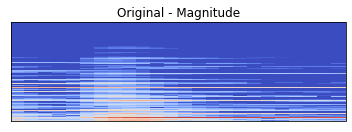

In [ ]:
k = np.random.randint(0,len(xm_data))

xxm, xxp = postprocess(xm_data[k], xp_data[k], mscaler, pscaler)

plt.subplot(221 if use_phase else 211)
show_spectrogram(xxm)
plt.title('Original - Magnitude')
if use_phase:
    plt.subplot(222)
    show_spectrogram(xxp)
    plt.title('Original - Phase')

print('sample clip:')
display(IPython.display.Audio(data=audio_recon(xxm,xxp if feature is not 'mel' else None), rate=sr))

## Creating a VAE

In [ ]:
chns, rows, cols = 1, df.Magnitude[0].shape[0], df.Magnitude[0].shape[1]
filters = 32

batch_size = 50
latent_dim = 100
middle_dim = 1000 # Not really used if phase is not used


epochs = 250

beta_max = 10
start_time = 0 * num_samples
ramp_time = 1 * num_samples
cycle_time = 5 * num_samples
num_cycles = 5

epsilon_std = 1.0
img_size = (rows,cols,chns)
img_size_reduced = rows // 8, cols // 12

ckptfilename = feature + str(n_fft if feature == 'stft' else n_bins) + 't'+str(epochs)+'h'+str(latent_dim)+'.h5'

In [ ]:
# =============================== Q(z|X) ======================================
x_mag = Input(shape=img_size,name='magnitude')
x_phi = Input(shape=img_size,name='phase')

# Mag Encoder
mconv1 = Conv2D(3*filters,(3,5),padding='same',activation='relu',strides=(2,3))(x_mag)
mconv2 = Conv2D(2*filters,(3,3),padding='same',activation='relu',strides=(1,1))(mconv1)
mconv3 = Conv2D(2*filters,(3,3),padding='same',activation='relu',strides=(1,1))(mconv2)
mpool1 = MaxPooling2D((2, 2), padding='same')(mconv3)
mconv4 = Conv2D(filters,(3,3),padding='same',activation='relu',strides=(1,1))(mpool1)
mconv5 = Conv2D(filters,(3,3),padding='same',activation='relu',strides=(1,1))(mconv4)
mpool2 = MaxPooling2D((2, 2), padding='same')(mconv5)
mconv  = Flatten()(mpool2)

# Phi Encoder
pconv1 = Conv2D(3*filters,(3,5),padding='same',activation='relu',strides=(2,3))(x_phi)
pconv2 = Conv2D(2*filters,(3,3),padding='same',activation='relu',strides=(1,1))(pconv1)
pconv3 = Conv2D(2*filters,(3,3),padding='same',activation='relu',strides=(1,1))(pconv2)
ppool1 = MaxPooling2D((2, 2), padding='same')(pconv3)
pconv4 = Conv2D(filters,(3,3),padding='same',activation='relu',strides=(1,1))(ppool1)
pconv5 = Conv2D(filters,(3,3),padding='same',activation='relu',strides=(1,1))(pconv4)
ppool2 = MaxPooling2D((2, 2), padding='same')(pconv5)
pconv  = Flatten()(ppool2)


# Intermediate Shared Layer - Encoder
shared_layer = Dense(middle_dim, activation='relu')
encoded_m = shared_layer(mconv)
encoded_p = shared_layer(pconv)
# encoded   = K.concatenate([encoded_m, encoded_p], axis=-1)
encoded   = keras.layers.concatenate([encoded_m, encoded_p])

# Latent Distribution
z_mean = Dense(latent_dim)(encoded if use_phase else mconv)
z_lvar = Dense(latent_dim)(encoded if use_phase else mconv)

In [ ]:
# =============================== Sampling ======================================
def sampling(args):
    z_mean, z_lvar = args
    bsize = K.shape(z_mean)[0]
    epsilon = K.random_normal(shape=(bsize, latent_dim),
                              mean=0.0, stddev=epsilon_std)
    return z_mean + K.exp(z_lvar / 2) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_lvar])

In [ ]:
# =============================== P(X|z) ======================================
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')

# Intermediate Shared Layer - Decoder
decode_h = Dense(middle_dim, activation='relu')

# Mag Decoder
decode_m   = decode_h(latent_inputs)
upsample_m = Dense(filters*img_size_reduced[0]*img_size_reduced[1], activation='relu')(decode_m if use_phase else latent_inputs)
ureshape_m = Reshape((img_size_reduced[0],img_size_reduced[1],filters))(upsample_m)
trconv1_m  = Conv2DTranspose(filters,3,padding='same', activation='relu',strides=1)(ureshape_m)
upsamp1_m  = UpSampling2D((2, 2))(trconv1_m)
trconv2_m  = Conv2DTranspose(filters,3,padding='same', activation='relu',strides=1)(upsamp1_m)
trconv3_m  = Conv2DTranspose(2*filters,3,padding='same', activation='relu',strides=1)(trconv2_m)
upsamp2_m  = UpSampling2D((2, 2))(trconv3_m)
trconv4_m  = Conv2DTranspose(2*filters,3,padding='same', activation='relu',strides=1)(upsamp2_m)
trconv5_m  = Conv2DTranspose(3*filters,(3,5),padding='same', activation='relu',strides=(2,3))(trconv4_m)
decoded_m  = Conv2D(chns,2,padding='same',activation='sigmoid',name='decoded_mag')(trconv5_m)


# Phi Decoder
decode_p   = decode_h(latent_inputs)
upsample_p = Dense(filters*img_size_reduced[0]*img_size_reduced[1], activation='relu')(decode_p)
ureshape_p = Reshape((img_size_reduced[0],img_size_reduced[1],filters))(upsample_p)
trconv1_p  = Conv2DTranspose(filters,3,padding='same', activation='relu',strides=1)(ureshape_p)
upsamp1_p  = UpSampling2D((2, 2))(trconv1_p)
trconv2_p  = Conv2DTranspose(filters,3,padding='same', activation='relu',strides=1)(upsamp1_p)
trconv3_p  = Conv2DTranspose(2*filters,3,padding='same', activation='relu',strides=1)(trconv2_p)
upsamp2_p  = UpSampling2D((2, 2))(trconv3_p)
trconv4_p  = Conv2DTranspose(2*filters,3,padding='same', activation='relu',strides=1)(upsamp2_p)
trconv5_p  = Conv2DTranspose(3*filters,(3,5),padding='same', activation='relu',strides=(2,3))(trconv4_p)
decoded_p  = Conv2D(chns,2,padding='same',activation='sigmoid',name='decoded_phi')(trconv5_p)

In [ ]:
# =============================== Loss ======================================

kl_weight = K.variable(0.0)

class LinearAnnealingCallback(Callback):
    def __init__(self, start_time=0, ramp_time=num_samples, cycle_time=2*num_samples, num_cycles=1, beta_max=0.5):
        self.ramp_time = ramp_time
        self.cycle_time = cycle_time
        self.num_cycles = num_cycles
        self.cycle_count = 0
        self.beta_max = beta_max
        self.start_time = start_time
        self.annealing = False

    def on_train_batch_begin(self, batch, logs=None):
        if self.num_cycles > 0:
            if not self.annealing:
                if self.cycle_count >= self.start_time:
                    self.cycle_count = 0
                    self.annealing = True
            if self.annealing:
                if self.cycle_count >= self.cycle_time:
                    self.num_cycles -= 1
                    self.cycle_count = 0
                    K.set_value(kl_weight, 0)
                else:
                    K.set_value(kl_weight, min(K.get_value(kl_weight) + (self.beta_max * batch_size / self.ramp_time), self.beta_max))
            self.cycle_count += batch_size
        else:
            K.set_value(kl_weight, self.beta_max)
        #print("\n%d: Current Anneal Weight is %f" % (batch, K.get_value(kl_weight)))

def recon_loss(y_true, y_pred):
    x = K.flatten(y_true)
    decoded = K.flatten(y_pred)
    gen_loss = rows * cols * metrics.mean_squared_error(x, decoded)
    return gen_loss
    
def kl_loss(y_true, y_pred):
    kl_loss = -0.5 * K.mean(1 + z_lvar - K.square(z_mean) - K.exp(z_lvar), axis=-1)
    return kl_loss

def annealing(y_true, y_pred):
    return kl_weight
        
def vae_loss(x, decoded):
    x = K.flatten(x)
    decoded = K.flatten(decoded)
    gen_loss = rows * cols * metrics.mean_squared_error(x, decoded)
    kl_loss = kl_weight * -0.5 * K.mean(1 + z_lvar - K.square(z_mean) - K.exp(z_lvar), axis=-1)
    return K.mean(gen_loss + kl_loss)

In [ ]:
# Model
if use_phase:
    # Encoder
    encoder = Model(inputs=([x_mag,x_phi]),outputs=[z_mean, z_lvar, z])

    # Decoder
    decoder = Model(inputs=latent_inputs, outputs=[decoded_m,decoded_p])
    outputs = decoder(encoder([x_mag,x_phi])[2])
    
    vae = Model(inputs=[x_mag, x_phi], outputs=outputs)
    vae.compile(optimizer='adam', loss=vae_loss, loss_weights=[1.0,0.1], metrics=[recon_loss, kl_loss])
else:
    # Encoder
    encoder = Model(inputs=([x_mag]),outputs=[z_mean, z_lvar, z])

    # Decoder
    decoder = Model(inputs=latent_inputs, outputs=[decoded_m])
    outputs = decoder(encoder([x_mag])[2])
    
    vae = Model(inputs=[x_mag], outputs=outputs)
    vae.compile(optimizer='adam', loss=vae_loss, loss_weights=[1.0], metrics=[recon_loss, kl_loss, annealing])
encoder.summary()
decoder.summary()
vae.summary()

import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
with tf.compat.v1.Session() as sess:
    writer = tf.compat.v1.summary.FileWriter(log_dir, sess.graph)
    writer.close()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
magnitude (InputLayer)          [(None, 1024, 24, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 8, 96)   1536        magnitude[0][0]                  
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 8, 64)   55360       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 8, 64)   36928       conv2d_1[0][0]                   
______________________________________________________________________________________________

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(encoder, to_file='encoder.png', show_shapes=True, show_layer_names=True)
plot_model(decoder, to_file='decoder.png', show_shapes=True, show_layer_names=True)
!cp encoder.png /content/drive/'My Drive'/'Colab Notebooks'/bitrate/encoder.png
!cp decoder.png /content/drive/'My Drive'/'Colab Notebooks'/bitrate/decoder.png

### Training is done here
you might be able to skip it if you have a previous checkpoint

In [ ]:
 vae.fit([xm_data,xp_data] if use_phase else [xm_data],[xm_data,xp_data] if use_phase else [xm_data],
                  shuffle=True,
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_data=([xm_data_t,xp_data_t] if use_phase else [xm_data_t], [xm_data_t,xp_data_t] if use_phase else [xm_data_t]),
                  callbacks=[#TensorBoard(log_dir=log_dir),
                             EarlyStopping(monitor='val_loss', patience=10),
                             LinearAnnealingCallback(beta_max=beta_max, start_time=start_time, ramp_time=ramp_time, cycle_time=cycle_time, num_cycles=num_cycles)])

Train on 4333 samples, validate on 2007 samples
Epoch 1/251
4333/4333 [==============================] - 13s 3ms/sample - loss: 465.2800 - recon_loss: 443.6357 - kl_loss: 2.1043 - annealing: 10.0000 - val_loss: 479.2605 - val_recon_loss: 457.4394 - val_kl_loss: 2.4359 - val_annealing: 10.0000
Epoch 2/251
4333/4333 [==============================] - 13s 3ms/sample - loss: 261.6490 - recon_loss: 240.6457 - kl_loss: 2.0875 - annealing: 10.0000 - val_loss: 422.6365 - val_recon_loss: 396.0269 - val_kl_loss: 2.5203 - val_annealing: 10.0000
Epoch 3/251
4333/4333 [==============================] - 13s 3ms/sample - loss: 220.9347 - recon_loss: 199.6666 - kl_loss: 2.1179 - annealing: 10.0000 - val_loss: 396.4694 - val_recon_loss: 370.0753 - val_kl_loss: 2.5452 - val_annealing: 10.0000
Epoch 4/251
4333/4333 [==============================] - 13s 3ms/sample - loss: 202.5365 - recon_loss: 181.3632 - kl_loss: 2.1217 - annealing: 10.0000 - val_loss: 383.5580 - val_recon_loss: 359.0474 - val_kl_loss: 

In [ ]:
# Save the model
vae.save('vae_'+ckptfilename)
encoder.save('e_'+ckptfilename)
decoder.save('d_'+ckptfilename)

print("Model saved in path: %s" % ckptfilename)

Model saved in path: stft2048t251h100.h5


### Alternatively, we can load a preexisting model

In [ ]:
vae.load_weights('vae_'+ckptfilename)
encoder.load_weights('e_'+ckptfilename)
decoder.load_weights('d_'+ckptfilename)
print("Model restored ", ckptfilename)

Model restored  stft2048t250h100.h5


## Quick Sanity check

In [ ]:
z = encoder.predict([xm_data_t,xp_data_t] if use_phase else [xm_data_t])
y = decoder.predict(z[2])
if use_phase:
    ymag = y[0]
    yphi = y[1]
else:
    ymag = y
    yphi = None

original clip:


reconstructed clip:


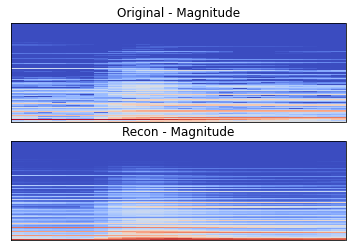

In [ ]:
k = np.random.randint(0,len(xm_data_t))
#k = 0
    
xxm, xxp = postprocess(xm_data_t[k], xp_data_t[k], mscaler_t, pscaler_t)
yym, yyp = postprocess(ymag[k], yphi[k] if use_phase else None, mscaler_t, pscaler_t)

plt.subplot(221 if use_phase else 211)
show_spectrogram(xxm)
plt.title('Original - Magnitude')
if use_phase:
    plt.subplot(222)
    show_spectrogram(xxp)
    plt.title('Original - Phase')

plt.subplot(223 if use_phase else 212)
show_spectrogram(yym)
plt.title('Recon - Magnitude')
if use_phase:
    plt.subplot(224)
    show_spectrogram(yyp)
    plt.title('Recon - Phase')

print('original clip:')
display(IPython.display.Audio(data=audio_recon(xxm,xxp if feature is not 'mel' else None), rate=sr))
print('reconstructed clip:')
display(IPython.display.Audio(data=audio_recon(yym,yyp if use_phase else None), rate=sr))


## Encoding-Decoding based Generation 
Up till now the VAE model was trained to reproduce individual music blocks (bars or longer) and generate new improvisation by random sampling from the latent space z.

Now we use a different midi file to create a sequence of latent variables z and model it with VMO
We also add a bit-rate control / data reduction of the z sequence


In [ ]:
# Load a single test file
q = './LABROSA-APT/test/WAV/bach_847MINp_align.wav'
#q = './bach_invention/wave_test/invention-14-left-120-4-4.wav'
q_df = get_song(q)
q_mag, _, q_mscaler, _  = preprocess(q_df)
ref_audio = np.concatenate(q_df.Wave)
display(IPython.display.Audio(data=ref_audio, rate=sr))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def get_power(x, eps=0, thresh=-80): #1e-12
    S = librosa.stft((x-np.mean(x))/np.sqrt((x**2).sum()), 2048)
    #S = librosa.stft(x, 2048)
    LS = 20*np.log10(np.abs(S) + eps)
    LSav = np.mean(LS, axis=1)
    ind = np.nonzero(LSav < thresh)
    LS[ind,:] = thresh
    return LS

def compute_log_distortion(x_hr, x_pr):
    min_len = min(len(x_hr), len(x_pr))
    LS1 = get_power(x_hr[:min_len])
    LS2 = get_power(x_pr[:min_len])
    lsd = (LS1-LS2)**2
    log_distortion = np.mean(np.sqrt(np.mean(lsd, axis=0)))
    log_s1 = np.mean(np.sqrt(np.mean(LS1**2, axis=0)))
    log_s2 = np.mean(np.sqrt(np.mean(LS2**2, axis=0)))
    return log_distortion, log_s1, log_s2, log_distortion/log_s1


### Baseline STFT-Griffin Lim Results

In [ ]:
S_o, _ = postprocess(np.concatenate(q_mag, axis=1), None, q_mscaler, None)
show_spectrogram(S_o)
baseline_audio = audio_recon(S_o, None)
display(IPython.display.Audio(data=baseline_audio, rate=sr))
sf.write('bach_847MINp_align_baseline.wav', baseline_audio, sr)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
ref = librosa.resample(ref_audio, sr, 16000)
base = librosa.resample(baseline_audio, sr, 16000)
#print('PESQ: ', pesq(16000, ref, base, 'wb'))
print('LSD: ', compute_log_distortion(ref, base))

LSD:  (2.7279034, 71.56051, 71.38082, 0.038120236)


### Encoder-Decoder results

In [ ]:
# Encode the VAE on query
zq_mu, zq_logvar, zq_sample = encoder.predict(q_mag)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
# Decode with the z from query and evaluate quality
samples = decoder.predict(zq_sample)
S_d, _ = postprocess(np.concatenate(samples, axis=1), None, q_mscaler, None)
show_spectrogram(S_d)
vae_audio = audio_recon(S_d, None)
display(IPython.display.Audio(data=vae_audio, rate=sr))
sf.write('bach_847MINp_align_vae.wav', vae_audio, sr)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
ed_audio = librosa.resample(vae_audio, sr, 16000)
#print('PESQ: ', pesq(16000, ref, ed_audio, 'wb'))
print('LSD: ', compute_log_distortion(ref, ed_audio))

LSD:  (7.1910286, 71.56051, 69.291916, 0.10048878)


# Reducing the bit-rate of latent states 
The experiment is described in Mume paper. The idea is to control the information rate between the input and the latent state before passing it to the decoder. The idea of bit-allocation is used to have quantitative control of the amount of information, but basically the process removes latent dimensions that have little energy (variance) and adds noise to the other dimensions, depending on the total number of bits allowed. 

### Rate control:
Rate is the value allowing to control the noisy channel model of limiting information rate between latent states and input. See the Mume paper.

In [ ]:
def reverse_water_filling(sigma2,bit_regime):
    bit_alloc = np.zeros(len(sigma2))
    tmp_s = 0
    tmp_s += sigma2
    for i in range(bit_regime):
        j = np.argmax(tmp_s)
        bit_alloc[j] += 1
        tmp_s[j] /= 4
    return bit_alloc

### Here equations of optimal channel (Berger) are implemented
![Screen%20Shot%202020-06-09%20at%209.03.20%20PM.png](attachment:Screen%20Shot%202020-06-09%20at%209.03.20%20PM.png)

In [ ]:
def Berger(zq_sample, bit_alloc):
    zq_mu = np.mean(zq_sample, axis = 0)
    zq_sig2 = np.var(zq_sample, axis=0)
           
    chan_mumul = (1-np.power(2,-2*bit_alloc))
    chan_sig2mul = np.power(2,-4*bit_alloc)*(np.power(2,2*bit_alloc)-1)
    chan_eps = np.random.randn(*np.shape(zq_sample))

    #Assuming zero mean and unit variance for the encoder Z:
    #quant_zq = np.matmul(zq_sample,np.diag(chan_mumul)) + np.matmul(chan_eps,np.diag(chan_sigmul)) 

    #Using the actual mean and variance of the encoder Z:
    quant_zq = np.matmul(zq_mu, np.diag(np.power(2,-2*bit_alloc))) + \
    np.matmul(zq_sample,np.diag(chan_mumul)) + \
    np.matmul(np.matmul(chan_eps,np.diag(np.sqrt(chan_sig2mul))),np.diag(np.sqrt(zq_sig2)))
    return quant_zq

## Comparison of the latent states before and after bit-allocation

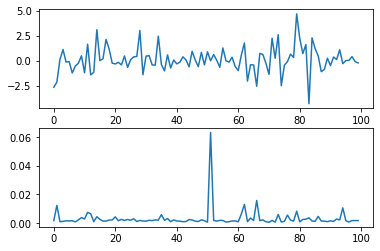

In [ ]:
zq_sig2 = np.mean(np.exp(zq_logvar), axis = 0)
plt.subplot(211)
plt.plot(np.mean(zq_sample,axis = 0))
plt.subplot(212)
plt.plot(zq_sig2)

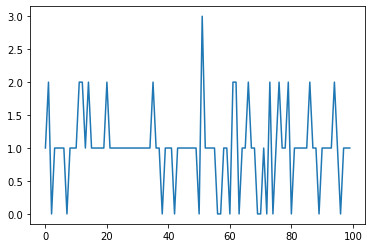

In [ ]:
Rate = 100
bit_alloc = reverse_water_filling(zq_sig2,Rate)
plt.plot(bit_alloc)
#print np.nonzero(bit_alloc)
quant_zq = Berger(zq_sample, bit_alloc)  #quantization

In [ ]:
# Decode with the z from bit allocation
samples = decoder.predict(quant_zq)
S_bd, _ = postprocess(np.concatenate(samples, axis=1), None, q_mscaler, None)
show_spectrogram(S_bd)
bit_audio = librosa.resample(audio_recon(S_bd, None), sr, 16000)
display(IPython.display.Audio(data=bit_audio, rate=16000))
sf.write('bach_847MINp_align_bit_reduce.wav', bit_audio, 16000)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#print('PESQ: ', pesq(16000, ref, bit_audio, 'wb'))
print('LSD: ', compute_log_distortion(ref, bit_audio))

LSD:  (8.131508, 71.56051, 68.57399, 0.11363122)


## Rate against metrics

### Metrics over rates



  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [03:14<29:09, 194.36s/it]

 20%|██        | 2/10 [06:31<26:01, 195.21s/it]

 30%|███       | 3/10 [09:49<22:52, 196.05s/it]

 40%|████      | 4/10 [13:04<19:33, 195.61s/it]

 50%|█████     | 5/10 [16:20<16:19, 195.83s/it]

 60%|██████    | 6/10 [19:40<13:08, 197.07s/it]

 70%|███████   | 7/10 [22:56<09:50, 196.70s/it]

 80%|████████  | 8/10 [26:11<06:32, 196.17s/it]

 90%|█████████ | 9/10 [29:26<03:15, 195.94s/it]

100%|██████████| 10/10 [32:40<00:00, 196.09s/it]


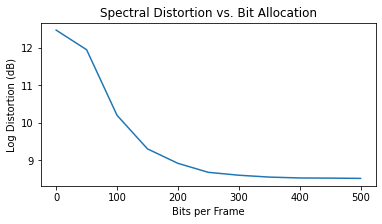

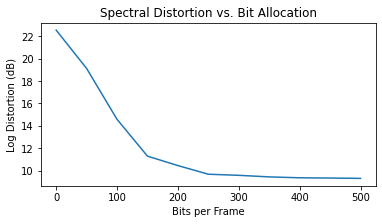

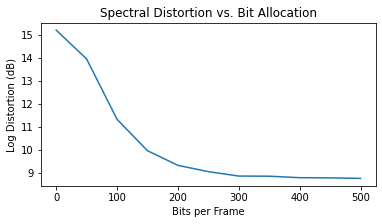

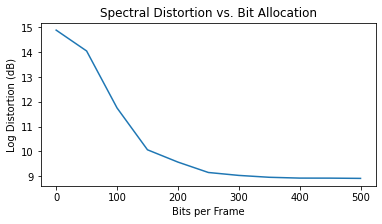

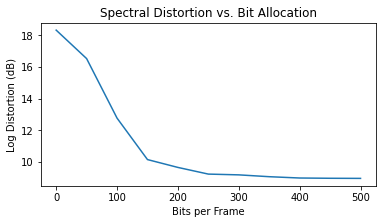

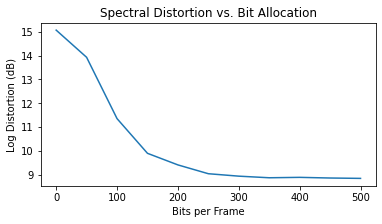

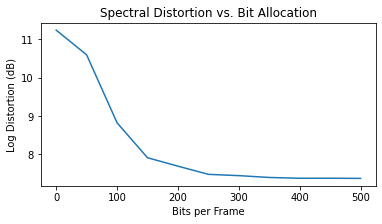

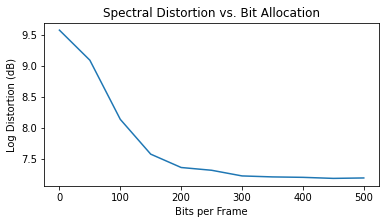

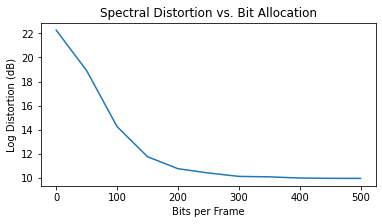

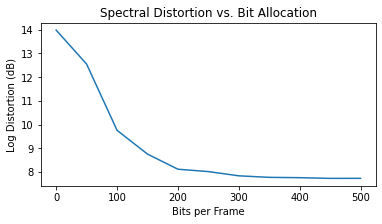

In [ ]:
# Thorough evaluation over all test files
files = glob.glob(('{}/*.wav*').format('LABROSA-APT/test/WAV'))
lsds = []

for f in tqdm(files):
    q_df = get_song(f)
    q_mag, _, q_mscaler, _  = preprocess(q_df)
    ref_audio = np.concatenate(q_df.Wave)
    
    zq_mu, zq_logvar, zq_sample = encoder.predict(q_mag)
    zq_sig2 = np.mean(np.exp(zq_logvar), axis = 0)
    Rates = np.linspace(0,500,11, dtype=np.int)[0:]
    lsds = []
    lsdrs = []
    for Rate in Rates:
        bit_alloc = reverse_water_filling(zq_sig2,Rate)
        quant_zq = Berger(zq_sample, bit_alloc)

        samples = decoder.predict(quant_zq)
        S_bd, _ = postprocess(np.concatenate(samples, axis=1), None, q_mscaler, None)
        ref = librosa.resample(ref_audio, sr, 16000)
        bit_audio = librosa.resample(audio_recon(S_bd, None), sr, 16000)
        lsd, _, _, lsdr = compute_log_distortion(ref, bit_audio)
        lsds.append(lsd)
        lsdrs.append(lsdr)
    
    plt.figure(figsize = (6,3))
    plt.plot(Rates, lsds)
    plt.title("Spectral Distortion vs. Bit Allocation")
    plt.ylabel('Log Distortion (dB)')
    plt.xlabel('Bits per Frame')
  

In [ ]:
Rates = np.linspace(0,500,51, dtype=np.int)[0:]
#Rates = [10, 100, 200, 500, 1000]
lsds = []
lsdrs = []
for Rate in Rates:
    bit_alloc = reverse_water_filling(zq_sig2,Rate)
    quant_zq = Berger(zq_sample, bit_alloc)

    samples = decoder.predict(quant_zq)
    S_bd, _ = postprocess(np.concatenate(samples, axis=1), None, q_mscaler, None)
    bit_audio = librosa.resample(audio_recon(S_bd, None), sr, 16000)

    #pesqs.append(pesq(16000, ref, bit_audio, 'wb'))
    lsd, _, _, lsdr = compute_log_distortion(ref, bit_audio)
    lsds.append(lsd)
    lsdrs.append(lsdr)
    print(Rate, lsds[-1], lsdrs[-1])

0 9.57591 0.13381556
10 9.571879 0.13375925
20 9.533022 0.13321625
30 9.383305 0.13112406
40 9.230549 0.12898943
50 9.109277 0.12729475
60 8.8792715 0.124080606
70 8.64298 0.12077862
80 8.453925 0.11813674
90 8.301259 0.11600336
100 8.114322 0.11339106
110 7.9321856 0.11084586
120 7.8099294 0.10913742
130 7.6684446 0.107160285
140 7.5737767 0.10583738
150 7.585399 0.10599979
160 7.5830526 0.105967
170 7.4967637 0.10476118
180 7.4443464 0.104028694
190 7.376753 0.10308413
200 7.3609066 0.10286269
210 7.356361 0.10279917
220 7.303055 0.10205426
230 7.333953 0.10248604
240 7.286926 0.10182887
250 7.2617874 0.101477586
260 7.296171 0.101958066
270 7.2581825 0.101427205
280 7.2556815 0.101392254
290 7.228527 0.101012796
300 7.23735 0.10113609
310 7.2448063 0.101240285
320 7.2203107 0.100897975
330 7.1986394 0.10059514
340 7.2129793 0.10079553
350 7.217736 0.100862
360 7.2072587 0.100715585
370 7.2126474 0.10079089
380 7.1982923 0.10059029
390 7.19303 0.10051675
400 7.196435 0.10056434
410 7

Text(0.5, 0, 'Bits per Frame')

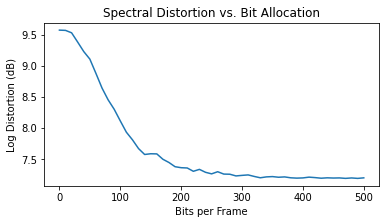

In [ ]:
#plt.subplot(211)
#plt.plot(Rates, pesqs)
#plt.title("PESQ")
#plt.gca().get_xaxis().set_visible(False)
#plt.subplot(212)
plt.figure(figsize = (6,3))
#plt.subplot(121)
plt.plot(Rates, lsds)
plt.title("Spectral Distortion vs. Bit Allocation")
plt.ylabel('Log Distortion (dB)')
plt.xlabel('Bits per Frame')
#plt.subplot(122)
#plt.plot(Rates, lsdrs)
#plt.title("Spectral Distortion Ratio vs. Bit Allocation")
#plt.ylabel('Log Distortion Ratio')
#plt.xlabel('Bits per Frame')
#plt.tight_layout()

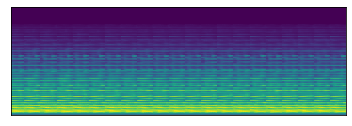

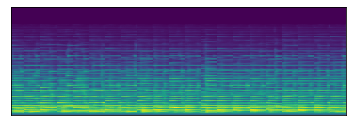

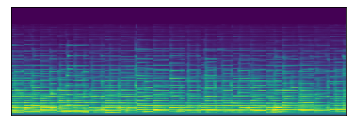

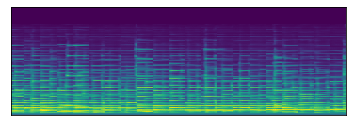

In [ ]:
Rates = [20,50,100,200]
lsds = []
lsdrs = []
for Rate in Rates:
    bit_alloc = reverse_water_filling(zq_sig2,Rate)
    quant_zq = Berger(zq_sample, bit_alloc)

    samples = decoder.predict(quant_zq)
    S_bd, _ = postprocess(np.concatenate(samples, axis=1), None, q_mscaler, None)
    plt.figure(figsize=(6,2))
    plt.imshow(S_bd[-600::-1,2500:3000], interpolation='nearest', aspect='auto')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)

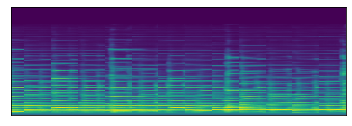

In [ ]:
plt.figure(figsize=(6,2))
plt.imshow(S_d[-600::-1,2500:3000], interpolation='nearest', aspect='auto')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)

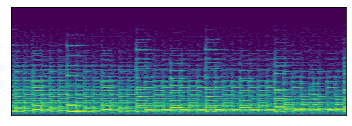

In [ ]:
plt.figure(figsize=(6,2))
plt.imshow(S_o[-600::-1,2500:3000], interpolation='nearest', aspect='auto')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)

### Average rate comparison across multiple songs

In [ ]:
# Average rate comparison across multiple songs
Rates = np.power(10,range(4))
files = glob.glob(('{}/*.wav*').format('LABROSA-APT/test/WAV'))
results = dict()
#results['baseline'] = []
#results['vae'] = []
for r in Rates:
    results['Rate=%d'%r] = []
for f in tqdm(files):
    q_df = get_song(q)
    q_mag, _, q_mscaler, _  = preprocess(q_df)
    ref_audio = librosa.resample(np.concatenate(q_df.Wave), sr, 16000)
    
    S_base, _ = postprocess(np.concatenate(q_mag, axis=1), None, mscaler, None)
    baseline_audio = librosa.resample(audio_recon(S_base, None), sr, 16000)
    #results['baseline'].append(pesq(16000, ref_audio, baseline_audio, 'wb'))
    
    zq_mu, zq_logvar, zq_sample = encoder.predict(q_mag)
    samples = decoder.predict(zq_sample)
    S_d, _ = postprocess(np.concatenate(samples, axis=1), None, mscaler, None)
    vae_audio = librosa.resample(audio_recon(S_d, None), sr, 16000)
    #results['vae'].append(pesq(16000, ref_audio, vae_audio, 'wb'))
    d = pesq(16000, ref_audio, vae_audio, 'wb')
    
    for r in Rates:
        zq_sig2 = np.mean(np.exp(zq_logvar), axis=0)
        bit_alloc = reverse_water_filling(zq_sig2,Rate)
        quant_zq = Berger(zq_sample, bit_alloc)
        samples = decoder.predict(quant_zq)
        S_b, _ = postprocess(np.concatenate(samples, axis=1), None, mscaler, None)
        bit_audio = librosa.resample(audio_recon(S_b, None), sr, 16000)
        results['Rate=%d'%r].append(pesq(16000, ref_audio, bit_audio, 'wb') - d)

  0%|          | 0/10 [00:01<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
names = list(results.keys())
values = list(results.values())

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))
axs.boxplot(values)
plt.setp(axs, xticks=[y + 1 for y in range(len(names))],
         xticklabels=names)

### VMO

In [ ]:
import vmo_copy
r = (0., 2.0, 0.01)
ideal_t = vmo_copy.find_threshold(zq_sample, r = r, dim=zq_sample.shape[1])
best_zq_oracle = vmo_copy.build_oracle(zq_sample, flag = 'a', threshold = ideal_t[0][1], dim=zq_sample.shape[1])
ideal_t[0][0]

584.507808390327

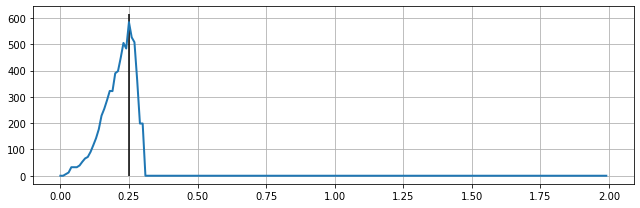

In [ ]:
x_t = np.array([t[1] for t in ideal_t[1]])
y_t = [t[0] for t in ideal_t[1]] 
plt.figure(figsize = (9,3))
plt.plot(x_t, y_t, linewidth = 2)
ymin, ymax = plt.ylim()
plt.vlines(ideal_t[0][1], 0, ymax)
plt.grid('on')
plt.tight_layout()

In [ ]:
import vmo_copy.analysis as van
import vmo_copy.generate as vge

bo = best_zq_oracle

b, kend, ktrace = vge.generate(bo, 120, 0.87, 1, LRS=2, weight='weight')
seq = np.array([zq_sample[i-1] for i in b])

ModuleNotFoundError: ignored

In [ ]:
samples = decoder.predict(seq) #this is reconstructio (decoding) from improvised latent sequence
S_d, _ = postprocess(np.concatenate(samples, axis=1), None, q_mscaler, None)
show_spectrogram(S_d)
vmo_audio = audio_recon(S_d, None)
display(IPython.display.Audio(data=vmo_audio, rate=sr))
sf.write('bach_847MINp_align_vmo.wav', vae_audio, sr)

NameError: ignored


0it [00:00, ?it/s]
1it [00:01,  1.72s/it]
2it [00:03,  1.74s/it]
3it [00:05,  1.74s/it]
4it [00:07,  1.76s/it]
5it [00:08,  1.80s/it]
6it [00:10,  1.82s/it]
7it [00:12,  1.83s/it]
8it [00:14,  1.87s/it]
9it [00:16,  1.88s/it]
10it [00:18,  1.88s/it]
11it [00:20,  1.89s/it]
12it [00:22,  1.90s/it]
13it [00:24,  1.89s/it]
14it [00:25,  1.88s/it]
15it [00:27,  1.88s/it]
16it [00:29,  1.88s/it]
17it [00:31,  1.89s/it]
18it [00:33,  1.88s/it]
19it [00:35,  1.88s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

20it [00:37,  1.90s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotli

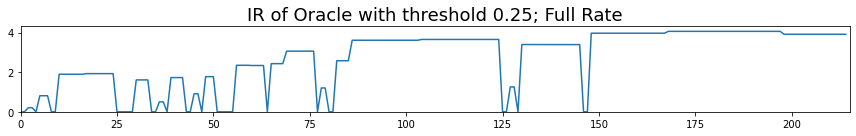

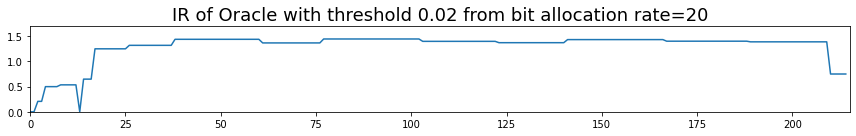

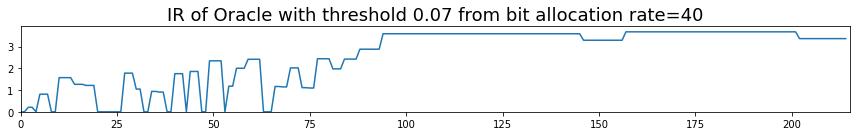

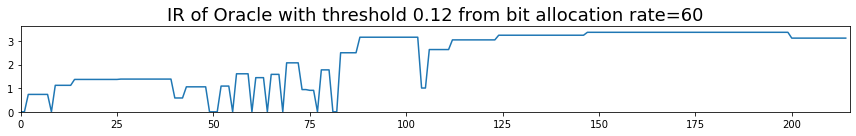

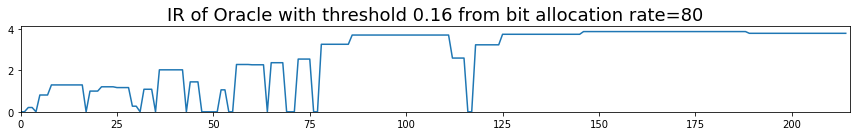

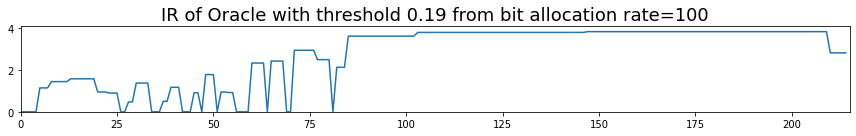

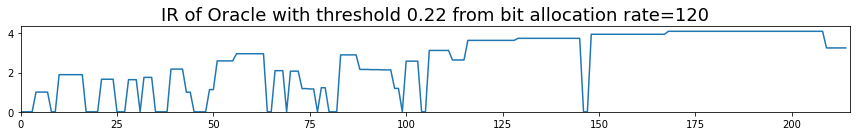

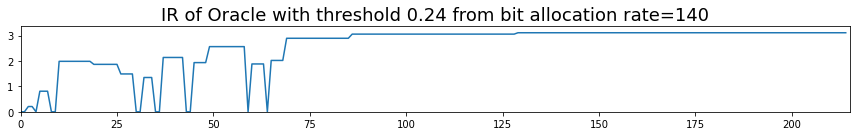

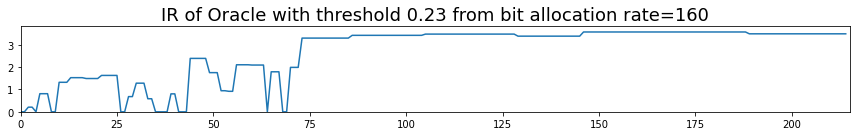

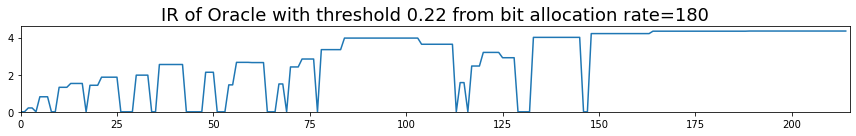

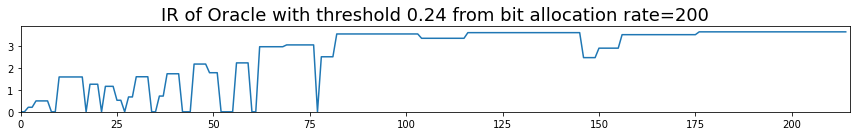

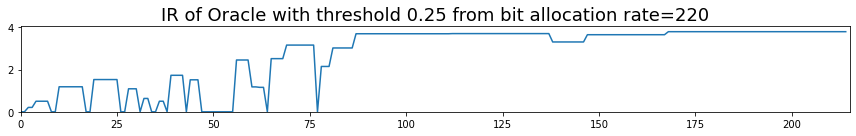

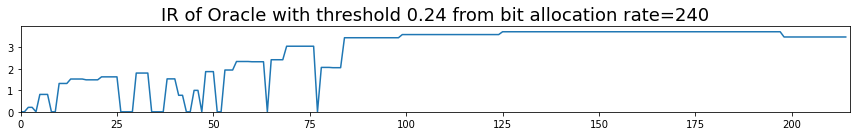

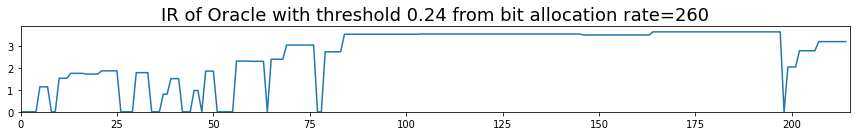

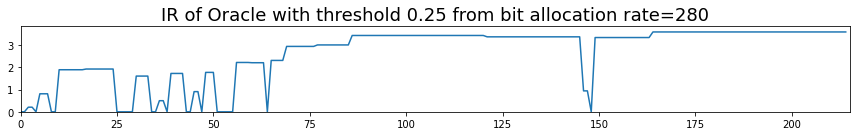

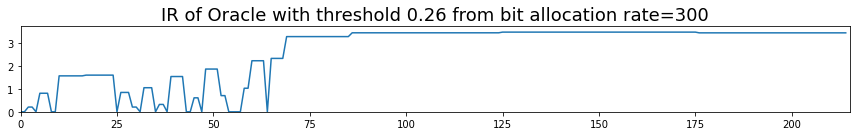

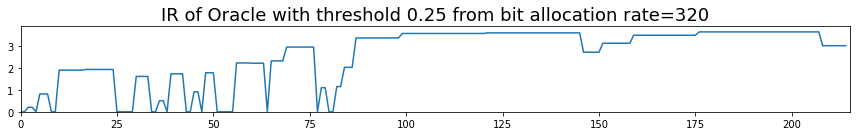

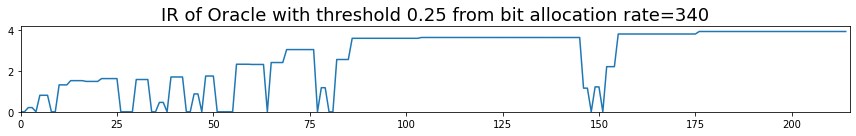

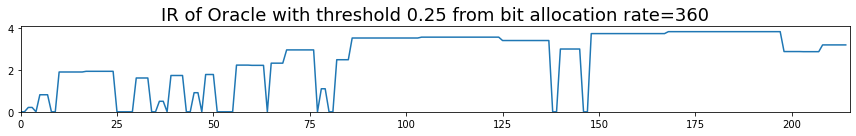

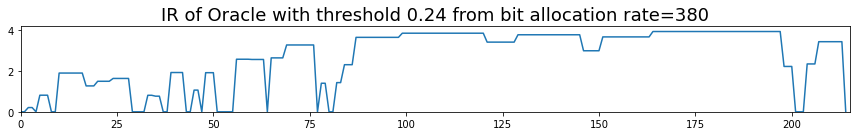

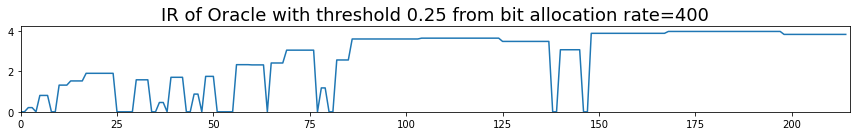

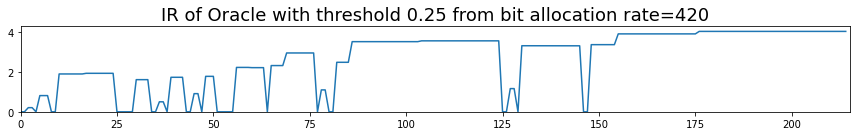

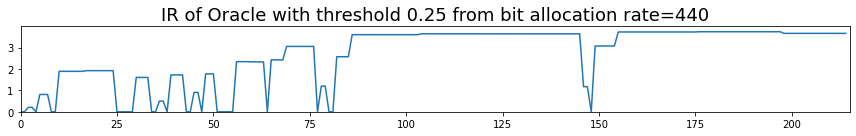

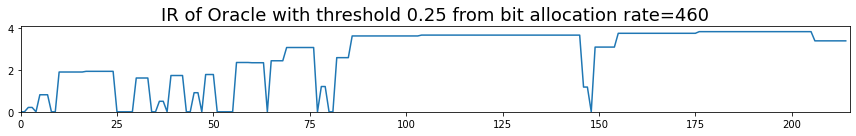

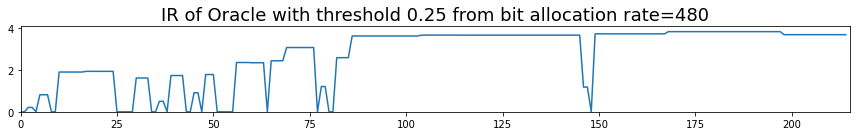

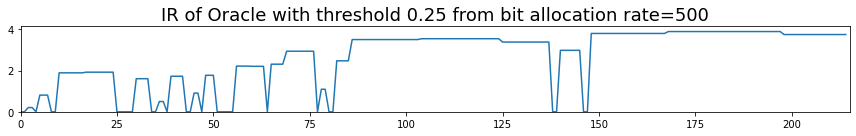

In [ ]:
Rates = np.linspace(0,500,26, dtype=np.int)[1:]

ideal_t = vmo_copy.find_threshold(zq_sample, r = r, dim=zq_sample.shape[1])
best_zq_oracle = vmo_copy.build_oracle(zq_sample, flag = 'a', threshold = ideal_t[0][1], dim=zq_sample.shape[1])
ir, h0, h1 = best_zq_oracle.IR()
plt.figure(figsize=(12,2))
plt.plot(ir)
plt.ylim((0, max(ir) + 0.25))
plt.xlim((0, len(ir)))
plt.title('IR of Oracle with threshold' + ' ' + str(ideal_t[0][1]) + '; Full Rate', fontsize=18)

plt.tight_layout()
for i, R in tqdm(enumerate(Rates)):
    bit_alloc = reverse_water_filling(zq_sig2,R)  #computer bit allocation for that song
    quant_zq = Berger(zq_sample, bit_alloc)  #quantize z with limited bit-rate
    ideal_t = vmo_copy.find_threshold(quant_zq, r = r, dim=quant_zq.shape[1])
    best_zq_oracle = vmo_copy.build_oracle(quant_zq, flag = 'a', threshold = ideal_t[0][1], dim=quant_zq.shape[1])

    ir, h0, h1 = best_zq_oracle.IR()
    plt.figure(figsize=(12,2))
    plt.plot(ir)
    plt.ylim((0, max(ir) + 0.25))
    plt.xlim((0, len(ir)))
    plt.title('IR of Oracle with threshold' + ' ' + str(ideal_t[0][1]) + ' from bit allocation rate=' + str(R), fontsize=18)
    plt.tight_layout()

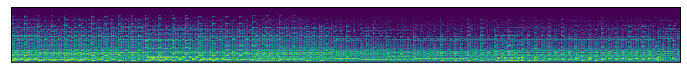

In [ ]:
plt.figure(figsize=(12,2))
plt.imshow(S_o[-600::-1,:], interpolation='nearest')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
#plt.ylim((0, max(ir) + 0.25))
#plt.xlim((0, len(ir)))
#plt.title('IR of Oracle with threshold' + ' ' + str(ideal_t[0][1]) + ' from bit allocation rate=' + str(R), fontsize=18)
#plt.tight_layout()

In [ ]:
import vmo_copy
r = (0., 2.0, 0.01)

num_songs = len(df_test.Magnitude)
# Average rate comparison across multiple songs
Rates = np.linspace(0,1000,21, dtype=np.int)[1:]
files = glob.glob(('{}/*.wav*').format('LABROSA-APT/test/WAV'))
num_songs = len(files)
IR = np.zeros((len(Rates),num_songs))
IT = np.zeros((len(Rates),num_songs))

for j, f in enumerate(files):
    print('Processing song ',j)
    q_df = get_song(q)
    q_mag, _, q_mscaler, _  = preprocess(q_df)
    ref_audio = librosa.resample(np.concatenate(q_df.Wave), sr, 16000)
    
    zq_mu, zq_logvar, zq_sample = encoder.predict(q_mag)
    zq_sig2 = np.mean(np.exp(zq_logvar), axis = 0)
    for i, R in enumerate(Rates):
        print(i,R)
        bit_alloc = reverse_water_filling(zq_sig2,R)  #computer bit allocation for that song
        quant_zq = Berger(zq_sample, bit_alloc)  #quantize z with limited bit-rate
        ideal_t = vmo_copy.find_threshold(quant_zq, r = r, dim=quant_zq.shape[1])
        IT[i,j] = ideal_t[0][1]
        IR[i,j] = ideal_t[0][0]

Processing song  0
0 50
1 100
2 150
3 200
4 250
5 300
6 350
7 400
8 450
9 500
10 550
11 600
12 650
13 700
14 750
15 800
16 850
17 900
18 950
19 1000
Processing song  1
0 50
1 100
2 150
3 200
4 250
5 300
6 350
7 400
8 450
9 500
10 550
11 600
12 650
13 700
14 750
15 800
16 850
17 900
18 950
19 1000
Processing song  2
0 50
1 100
2 150
3 200
4 250
5 300
6 350
7 400
8 450
9 500
10 550
11 600
12 650
13 700
14 750
15 800
16 850
17 900
18 950
19 1000
Processing song  3
0 50
1 100
2 150
3 200
4 250
5 300
6 350
7 400
8 450
9 500
10 550
11 600
12 650
13 700
14 750
15 800
16 850
17 900
18 950
19 1000
Processing song  4
0 50
1 100
2 150
3 200
4 250
5 300
6 350
7 400
8 450
9 500
10 550
11 600
12 650
13 700
14 750
15 800
16 850
17 900
18 950
19 1000
Processing song  5
0 50
1 100
2 150
3 200
4 250
5 300
6 350
7 400
8 450
9 500
10 550
11 600
12 650
13 700
14 750
15 800
16 850
17 900
18 950
19 1000
Processing song  6
0 50
1 100
2 150
3 200
4 250
5 300
6 350
7 400
8 450
9 500
10 550
11 600
12 650
13 700


10


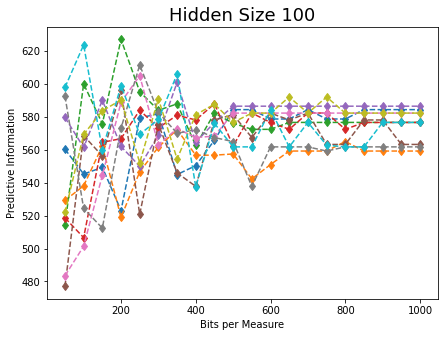

In [ ]:
print(num_songs)
for k in range(num_songs):
    #if all(IR[:,k] != 0):
        #print('OK',k)
    plt.plot(Rates,IR[:,k],'d--')

#plt.plot(Rates,np.mean(IR,1))
#plt.yscale('log')
   
ttl = 'Hidden Size '+str(latent_dim)
    
#num_timesteps  = 16 #64 #32 #16 #This is the number of timesteps that we will create at a time  (16 = one bar)
#n_visible      = 2*note_range*num_timesteps #This is the size of the visible layer. 
#n_hidden       = 3000 #500  #50 #This is the size of the hidden layer
#plt.rcParams.update({'font.size': 12})

SMALL_SIZE = 12 #8
MEDIUM_SIZE = 16 #10
BIGGER_SIZE = 18

#plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig = plt.gcf()
plt.title(ttl)
plt.ylabel('Predictive Information')
plt.xlabel('Bits per Measure')
fig.set_size_inches(7, 5.0)

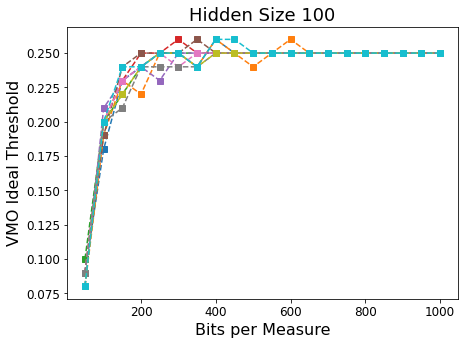

In [ ]:
for k in range(num_songs):
    #if all(IT[:,k] != 0):
#        print('OK',k)
    plt.plot(Rates,IT[:,k],'s--')
        
ttl = 'Hidden Size '+str(latent_dim)
    
#num_timesteps  = 16 #64 #32 #16 #This is the number of timesteps that we will create at a time  (16 = one bar)
#n_visible      = 2*note_range*num_timesteps #This is the size of the visible layer. 
#n_hidden       = 3000 #500  #50 #This is the size of the hidden layer
#plt.rcParams.update({'font.size': 12})

SMALL_SIZE = 12 #8
MEDIUM_SIZE = 16 #10
BIGGER_SIZE = 18

#plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig = plt.gcf()
plt.title(ttl)
plt.ylabel('VMO Ideal Threshold')
plt.xlabel('Bits per Measure')
fig.set_size_inches(7, 5.0)